# Noise2Void Experiment

[CVPR 2019 : Noise2Void - Learning Denoising from Single Noisy Image](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf)

Key idea: 
- Blind-spot network(BSN), network learn the mapping between mask pixel(s) and every other pixels
- the expect of output identical to clean image when noise mean is zero and i.i.d and there traing data inf.

Pros: 
1. single noisy image denoising, has tremendous practicality on medical denoising task
2. can adaptive to any noise distribution since its learn denoising directly from noisy image 

Cons:
1. by masking certain pixel(s), the quality of denoising decrease, especially for high-frequency content
2. strong assumption of zero mean noise and pixels i.i.d, leading to poor performance when it dealing with structured noise 
3. denoising performance slightly degrade to N2N but still better than BM3D

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image
from module.datasets import load_4d_dicom, save_4d_dicom

import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load noisy dataset

Noisy data...float64 (shape:(24, 71, 192, 192); range:[-0.018414393986850297,1.0298518324719883]; mean:0.5030665574527993); std:0.02335746313650884
b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'


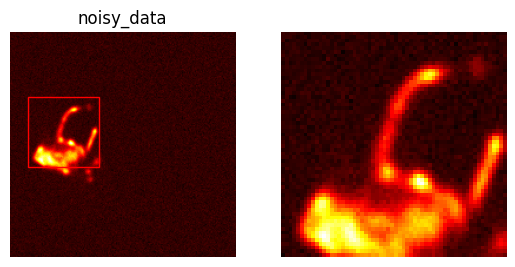

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gauss_0.009.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = f['restore_info'][...]
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)
display_image_in_detail(noisy_data[11, 38], title='noisy_data')

## Process Denoising

## 1. define denoising network

In [3]:
class AttentionModule(nn.Module):
    """
        Attention module to provide self-attention within a channel dimension.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels, out_channels):
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        q = self.conv1(x)
        k = self.conv2(x)
        attn = self.softmax(torch.matmul(q, k.transpose(-1, -2)))
        out = torch.matmul(attn, k)
        return out + x


class UNetBlock(nn.Module):
    """
        Basic UNet block comprising two convolutional layers with batch normalization and ReLU activation.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.in_channels = in_channels  # Add this line
        self.encoder1 = UNetBlock(self.in_channels * 3, 64)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # if not in_channel == out_channel, using 1x1 conv2d to fix
        if in_channels != out_channels:
            self.match_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.match_channels = None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # if not in_channel == out_channel, using 1x1 conv2d to fix
        if self.match_channels:
            residual = self.match_channels(x)

        out += residual
        out = self.relu(out)
        return out


class UNet2_5D(nn.Module):
    """
         2.5D UNet architecture with self-attention at the bottleneck.
        Takes three consecutive slices (top, middle, bottom) as input and predicts the middle slice.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels (usually number of classes).
    """
    def __init__(self, in_channels, out_channels):
        super(UNet2_5D, self).__init__()
        # Multiply in_channels by 3 as there are 3 slices: top, middle, bottom
        self.encoder1 = UNetBlock(in_channels * 3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = UNetBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = UNetBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = UNetBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.encoder5 = UNetBlock(512, 1024)
        self.pool5 = nn.MaxPool2d(2)

        self.center = nn.Sequential(
            UNetBlock(1024, 2048),
            AttentionModule(2048, 2048)
        )

        self.up5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder5 = UNetBlock(2048, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = UNetBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = UNetBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = UNetBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = UNetBlock(128, 64)
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x_top, x_middle, x_bottom):
        """
        Forward pass for the 2.5D UNet.

        Args:
            x_top (torch.Tensor): Input tensor for the top slice (batch_size, in_channels, height, width).
            x_middle (torch.Tensor): Input tensor for the middle slice (batch_size, in_channels, height, width).
            x_bottom (torch.Tensor): Input tensor for the bottom slice (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Output tensor for the middle slice (batch_size, out_channels, height, width).
        """
         # Concatenate the channels from the top, middle, and bottom slices
        x = torch.cat([x_top, x_middle, x_bottom], dim=1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))
        center = self.center(self.pool5(enc5))
        dec5 = self.decoder5(torch.cat([enc5, self.up5(center)], 1))
        dec4 = self.decoder4(torch.cat([enc4, self.up4(dec5)], 1))
        dec3 = self.decoder3(torch.cat([enc3, self.up3(dec4)], 1))
        dec2 = self.decoder2(torch.cat([enc2, self.up2(dec3)], 1))
        dec1 = self.decoder1(torch.cat([enc1, self.up1(dec2)], 1))
        final = self.conv_final(dec1)
        return final


## 2. create mask dataset and dataloader

In [4]:
        
class Mask2_5Dataset(Dataset):
    def __init__(self, noisy_data, apply_mask=True, n_mask = 1):
        self.noisy_data = noisy_data
        self.apply_mask = apply_mask
        self.n_mask = n_mask

    def __len__(self):
        return self.noisy_data.shape[0] * (self.noisy_data.shape[2] - 2)

    def __getitem__(self, idx):
        time_idx = idx // (self.noisy_data.shape[2] - 2)
        depth_idx = idx % (self.noisy_data.shape[2] - 2)
        x_top = self.noisy_data[time_idx, :, depth_idx]
        x_middle = self.noisy_data[time_idx, :, depth_idx + 1]
        x_bottom = self.noisy_data[time_idx, :, depth_idx + 2]

        if self.apply_mask:
            x_middle, mask_middle = self.mask(x_middle)
            return x_top, x_middle, x_bottom, mask_middle
        else:
            return x_top, x_middle, x_bottom

    def mask(self, x):
        n = self.n_mask  # Number of pixels to mask
        mask_middle = torch.ones_like(x)  # Initialize the mask
        x_noised = x.clone()  # Create a copy for the noised data
        random_idx = torch.randint(0, x.numel(), (n,))  # Random indexing for tensors
        mask_middle.view(-1)[random_idx] = 0
        #x_noised.view(-1)[random_idx] = torch.normal(mean=0, std=1, size=(n,))  # or any noise you want to introduce
        x_noised.view(-1)[random_idx] = 0
        return x_noised, mask_middle


In [5]:
noisy_tensor = torch.tensor(noisy_data[:, np.newaxis, :, :, :], dtype=torch.float32)

noisy_tensor = noisy_tensor.to(device)

print(f"noisy_tensor shape: {noisy_tensor.shape}")

noisy_dataset = Mask2_5Dataset(noisy_tensor, apply_mask=True, n_mask=1)
noisy_dataloader = DataLoader(noisy_dataset, batch_size=32, shuffle=True)

noisy_tensor shape: torch.Size([24, 1, 71, 192, 192])


Top slice shape: torch.Size([32, 1, 192, 192])
Middle slice shape: torch.Size([32, 1, 192, 192])
Bottom slice shape: torch.Size([32, 1, 192, 192])
mask_middle shape: torch.Size([32, 1, 192, 192]); num of count<1.0: 32; mean: 0.9999728798866272


Text(0.5, 1.0, 'x_bottom')

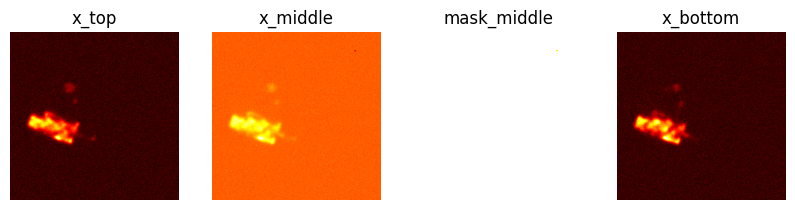

In [6]:
# example data batch

noisy_data_iterator = iter(noisy_dataloader)
x_top, x_middle, x_bottom, mask_middle = next(noisy_data_iterator)
print("Top slice shape:", x_top.shape)
print("Middle slice shape:", x_middle.shape)
print("Bottom slice shape:", x_bottom.shape)
print(f"mask_middle shape: {mask_middle.shape}; num of count<1.0: {torch.sum(mask_middle < torch.mean(mask_middle)).item()}; mean: {torch.mean(mask_middle)}")


# example batch display
batch_num = 0
batch_num = min(batch_num, x_middle.shape[0] - 1)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(x_top.cpu()[batch_num, 0], cmap='hot')
axs[0].axis('off')
axs[0].set_title("x_top")
axs[1].imshow(x_middle.cpu()[batch_num, 0], cmap='hot')
axs[1].axis('off')
axs[1].set_title("x_middle")
axs[2].imshow(mask_middle.cpu()[batch_num, 0], cmap='hot')
axs[2].axis('off')
axs[2].set_title("mask_middle")
axs[3].imshow(x_bottom.cpu()[batch_num, 0], cmap='hot')
axs[3].axis('off')
axs[3].set_title("x_bottom")

## 3.  define training modules

In [7]:
model = UNet2_5D(in_channels=1, out_channels=1)


# print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))


# model = model.to(device)

: 

: 

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 4. process training

In [ ]:
epochs = 1000

for epoch in range(epochs):
    for batch in noisy_dataloader:
        x_top, x_middle, x_bottom, mask_middle = batch
        optimizer.zero_grad()
        outputs = model(x_top, x_middle, x_bottom)
        loss = criterion(outputs, x_middle) # Depending on how you define targets
        loss.backward()
        optimizer.step()

## Evaluation

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised result
mean_val = 201.12048776036573
std_val = 1412.4139804758772
min_val = -23.34168377224119
max_val = 23.05689405684542

denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)


print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

display_image_in_detail(denormalized_denoised_data[11, 38])

In [ ]:
# save as dicom files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'
output_folder = './dataset/denoised/N2V/PT_20p 150_120 OSEM_gauss_0.009'

save_4d_dicom(origin_dicom_folder, denormalized_denoised_data, output_folder)